In [1]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv

# Load from env
load_dotenv()

model = init_chat_model("gpt-4o-mini")

In [2]:
from pathlib import Path
import sys
# append dev directory to sys.path
sys.path.insert(0, str(Path.cwd().parent / "agent"))

In [3]:

# Import the data exploration agent
from data_exploration_subagent import build_agent as build_data_exploration_agent
from langchain.tools import tool

# Build the data exploration agent
data_exploration_agent = build_data_exploration_agent()

# Wrap data_exploration_agent as a tool
@tool("data_exploration_agent", description="Use this agent to explore and query the art database. Provide a natural language question about the art data.")
def call_data_exploration_agent(query: str) -> str:
    """
    Call the data exploration agent to answer questions about the art database.
    
    Args:
        query: A natural language question about the art data
        
    Returns:
        The response from the data exploration agent
    """
    result = data_exploration_agent.invoke(
        {"messages": [{"role": "user", "content": query}]}
    )
    return result["messages"][-1].content

In [4]:
# Image qna tools for main_agent
# import importlib
# import sys

# # Ensure fresh import
# if 'image_qna_tool' in sys.modules:
#     importlib.reload(sys.modules['image_qna_tool'])

from image_qna_tool import build_image_qna_tool
image_qna_tool = build_image_qna_tool()

/home/afiq/fyp/fafa-repo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
tools = [
    image_qna_tool,
    call_data_exploration_agent,
]

tools_by_name = {tool.name: tool for tool in tools}


In [6]:
from typing import Literal
from langgraph.graph import END, MessagesState
from langchain_core.messages import AIMessage, ToolMessage

# Node: Process user query with main agent
main_agent_system_prompt = """
You are a helpful assistant designed to solve tasks/ question about the art database.
You have access to a specialized data exploration agent that can query the art database.
You also have access to a tool that can answer questions related to the images in the database.

When users ask questions about the art database, use the data_exploration_agent tool to find the answers.
When users ask questions in regard to the visuals images in the database, use the image_qna_tool to find the answers.

You can ask the agent multi-step questions and use the results to provide comprehensive responses.
"""


def process_query(state: MessagesState):
    """Process user query with the main agent."""
    system_message = {
        "role": "system",
        "content": main_agent_system_prompt,
    }
    llm_with_tools = model.bind_tools([image_qna_tool, call_data_exploration_agent])
    response = llm_with_tools.invoke([system_message] + state["messages"])
    
    return {"messages": [response]}


# # Node: Call data exploration agent
# def call_agent(state: MessagesState):
#     """Call the data exploration agent tool."""
#     tool_call = state["messages"][-1].tool_calls[0]
#     result = call_data_exploration_agent.invoke(tool_call["args"]["query"])
    
#     tool_message = ToolMessage(
#         content=result,
#         tool_call_id=tool_call["id"],
#         name="data_exploration_agent",
#     )
    
#     return {"messages": [tool_message]}

def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function
def should_continue(state: MessagesState) -> Literal[END, "tool_execution"]:
    """Determine if we should call the agent or end."""
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "tool_execution"


In [7]:
from langgraph.graph import START, StateGraph

# Build the main agent graph
def build_main_agent():
    """Build the main agent graph with data exploration agent as subagent."""
    builder = StateGraph(MessagesState)
    builder.add_node("process_query", process_query)
    builder.add_node("tool_execution", tool_node)
    
    builder.add_edge(START, "process_query")
    builder.add_conditional_edges(
        "process_query",
        should_continue,
    )
    builder.add_edge("tool_execution", "process_query")
    
    return builder.compile()


# Initialize the main agent
main_agent = build_main_agent()

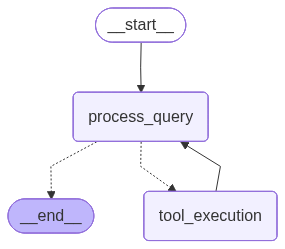

In [8]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(main_agent.get_graph().draw_mermaid_png()))

In [9]:
questions = [
    # "Which genre has the oldest painting?",
    # "How many paintings are there from the Renaissance period?",
    "What is shown in the painting image with the oldest year?",
]

for question in questions:
    print(f"\nQuestion: {question}")
    print("-" * 50)
    
    for step in main_agent.stream(
        {"messages": [{"role": "user", "content": question}]},
        stream_mode="values",
    ):
        step["messages"][-1].pretty_print()


Question: What is shown in the painting image with the oldest year?
--------------------------------------------------
================================ Human Message =================================

What is shown in the painting image with the oldest year?
================================== Ai Message ==================================
Tool Calls:
  data_exploration_agent (call_v2FUw9kg24pBMrO88K3iL3a8)
 Call ID: call_v2FUw9kg24pBMrO88K3iL3a8
  Args:
    query: Find the painting image with the oldest year.
================================= Tool Message =================================

The painting with the oldest year is titled **"Predella of the Barbadori altarpiece"**, created in **1438**. The image can be found at **images/img_0.jpg**.
================================== Ai Message ==================================
Tool Calls:
  image_qna_tool (call_ITWe1Lf7nbczq2hHEv7kupf1)
 Call ID: call_ITWe1Lf7nbczq2hHEv7kupf1
  Args:
    img_url: images/img_0.jpg
    question: What is show